# Lending Club
The given dataset contains the loan deatils of the lending company from 2007 to 2011. The data given in dataset contains information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

In [312]:
#Import all the necessary libraries here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

<h1>Loading Data</h1>

In [313]:
#loading data
loan_df = pd.read_csv("loan.csv", dtype={'next_pymnt_d': 'string'})
loan_df.shape #data set has 39717 rows and 111 columns
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


<h1>Data Cleaning</h1> <br/>
Removing all the columns which has only missing values. Data in these columns has no significance in data analysis.

In [314]:
loan_df_all_null = list(loan_df.columns[loan_df.isnull().sum() == len(loan_df.index)])
(loan_df.isnull().sum()/len(loan_df.index))*100

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
                                 ...    
tax_liens                       0.098195
tot_hi_cred_lim               100.000000
total_bal_ex_mort             100.000000
total_bc_limit                100.000000
total_il_high_credit_limit    100.000000
Length: 111, dtype: float64

In [315]:
#finding & droping columns having missing values > 60%
loan_df_all_null.extend(['mths_since_last_record','next_pymnt_d','mths_since_last_delinq'])

In [316]:
#finding distinct values for pymnt_plan, it has only single value as n, so it has no significance in analysis
#acc_now_delinq only 0 value
#chargeoff_within_12_mths only 0.0 value
#delinq_amnt only 0 value
#initial_list_status has only `f` values
#policy_code has only `1` values
#collections_12_mths_ex_med has only `0.0` values
#id and member_id has unique values, so there is no any corellation with other features
#tax_liens has only 0.0 value
#desc requires NLP to derive the useful metric, currently it is removing
#application_type has only single value `Individual`
#url
#zip_code has encrypted values
loan_df_all_null.extend(['pymnt_plan','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt', 
                         'initial_list_status','policy_code','collections_12_mths_ex_med','id',
                         'member_id','tax_liens','desc','application_type','url','zip_code'])

In [317]:
#Customer behavioural variables are not available at the time of loan application. So removing those variables
loan_df_all_null.extend(['delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
                       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
                       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
                       'total_rec_int', 'total_rec_late_fee', 'recoveries',
                       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
                       'last_credit_pull_d','pub_rec_bankruptcies'])

In [318]:
loan_df_all_null = set(loan_df_all_null) #will remove duplicate column name values if any
loan_df_all_null = list(loan_df_all_null)

In [319]:
#First creating filter so it will check column exist or not, while droping column not exists error will not come
dropFilter = loan_df.filter(loan_df_all_null)
loan_df.drop(dropFilter, axis=1, inplace=True)
loan_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti'],
      dtype='object')

<h3>Missing Value Imputation</h3>

In [320]:
#filling null values in emp_title with Untitled
loan_df.emp_title.fillna("Untitled", inplace = True)
#filling null values in emp_length & title with Unknown
loan_df.emp_length.fillna("Unknown", inplace = True)
loan_df.title.fillna("Unknown", inplace = True)

In [321]:
#checking dti ratio is less than 0
loan_df[loan_df['dti'] < 0] 
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            39717 non-null  int64  
 1   funded_amnt          39717 non-null  int64  
 2   funded_amnt_inv      39717 non-null  float64
 3   term                 39717 non-null  object 
 4   int_rate             39717 non-null  object 
 5   installment          39717 non-null  float64
 6   grade                39717 non-null  object 
 7   sub_grade            39717 non-null  object 
 8   emp_title            39717 non-null  object 
 9   emp_length           39717 non-null  object 
 10  home_ownership       39717 non-null  object 
 11  annual_inc           39717 non-null  float64
 12  verification_status  39717 non-null  object 
 13  issue_d              39717 non-null  object 
 14  loan_status          39717 non-null  object 
 15  purpose              39717 non-null 

<h3>Data Type Correction</h3>

In [322]:
#make term as integer, removing months word
if loan_df.term.dtype != int:
    loan_df.term = loan_df.term.apply(lambda x: int(x.replace('months','')) if (loan_df.term.dtype != int) & ("months" in x) else int(x))    
loan_df.term.dtype    

dtype('int64')

In [323]:
#interest rate should be float value, removing % sign
if loan_df.int_rate.dtype != float:
    loan_df.int_rate = loan_df.int_rate.apply(lambda x: float(x.replace('%','')) if (loan_df.int_rate.dtype != float) & ("%" in x) else float(x))   
loan_df.int_rate.dtype

dtype('float64')

In [324]:
#check duplicate rows based on all the columns
loan_df[loan_df.duplicated()]
#There are no duplicate rows found in the dataset

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti


<h3>New metric creation</h3>

In [325]:
#adding percentage of monthly installment amount to monthly income
loan_df['monthly_inst_percentage'] = (loan_df['installment']/(loan_df['annual_inc']/12))*100
#creating bins for dti, annual_income, int_rate
loan_df['dti_bin'], cut_bin = pd.qcut(loan_df['dti'], q = 15, retbins = True)
loan_df['ann_inc_bin'], cut_bin = pd.qcut(loan_df['annual_inc'], q = 20, retbins = True)
loan_df['int_rate_bin'], cut_bin = pd.qcut(loan_df['int_rate'], q = 20, retbins = True)
#deriving issue_d to continuous month and year
loan_df['issue_month'] = loan_df.issue_d.apply(lambda x: int(datetime.strptime(x.split('-')[0], '%b').month))
loan_df['issue_year'] = loan_df.issue_d.apply(lambda x: int(x.split('-')[1]))
loan_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,purpose,title,addr_state,dti,monthly_inst_percentage,dti_bin,ann_inc_bin,int_rate_bin,issue_month,issue_year
0,5000,5000,4975.0,36,10.65,162.87,B,B2,Untitled,10+ years,...,credit_card,Computer,AZ,27.65,8.143500,"(23.27, 29.99]","(3999.999, 24000.0]","(10.59, 10.99]",12,11
1,2500,2500,2500.0,60,15.27,59.83,C,C4,Ryder,< 1 year,...,car,bike,GA,1.00,2.393200,"(-0.001, 2.827]","(24000.0, 30000.0]","(14.59, 15.27]",12,11
2,2400,2400,2400.0,36,15.96,84.33,C,C5,Untitled,10+ years,...,small_business,real estate business,IL,8.72,8.259549,"(8.56, 10.01]","(3999.999, 24000.0]","(15.27, 16.0]",12,11
3,10000,10000,10000.0,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,other,personel,CA,20.00,8.275854,"(19.75, 21.41]","(48000.0, 50400.0]","(13.47, 13.92]",12,11
4,3000,3000,3000.0,60,12.69,67.79,B,B5,University Medical Group,1 year,...,other,Personal,OR,17.94,1.016850,"(16.75, 18.2]","(75600.0, 82300.0]","(12.42, 12.87]",12,11


<h1>Outliers</h1>

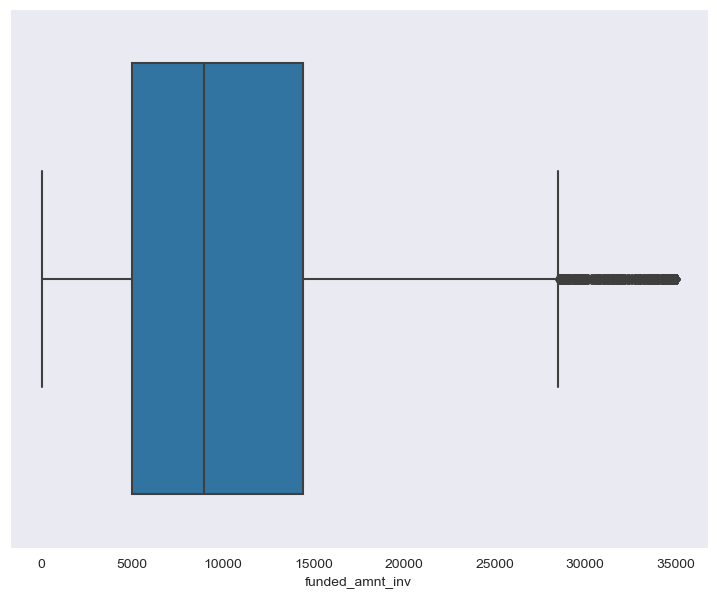

In [343]:
#box plot to check outliers
plt.figure(figsize=[9,7])
sns.boxplot(loan_df, x=loan_df['funded_amnt_inv']) 
plt.show()

<h3>Data Filtering</h3>

In [327]:
#Analysing only Charged Off & Fully Paid loan. 
#loan accounts having status as `Current` are uncertain that it will result into charged off or Fully Paid
loan_df_loan_stat = loan_df[loan_df['loan_status'].isin(['Charged Off','Fully Paid'])]

<h3>Analysis</h>

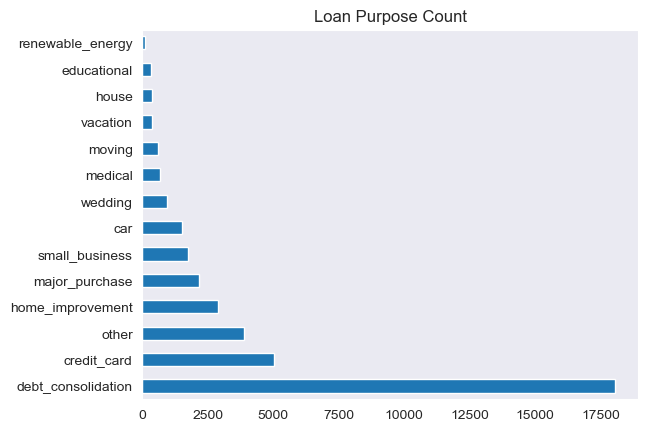

In [328]:
loan_df_loan_stat['purpose'].value_counts().plot.barh(title="Loan Purpose Count")
plt.show()
#The count of debt_consolidation loan type is maximum

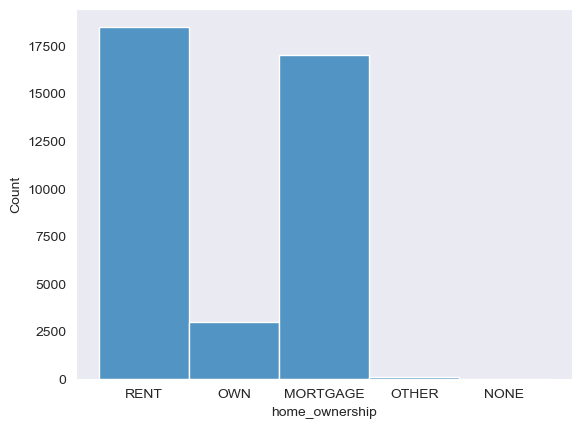

In [329]:
sns.histplot(loan_df_loan_stat, x="home_ownership")
plt.show()
#People having own house are not likely to take loans
#Recomendations
#We can promote people having home ownership as `Own` by offering less intrest rate. 
#These will be more secure as compared to Rent borrowers

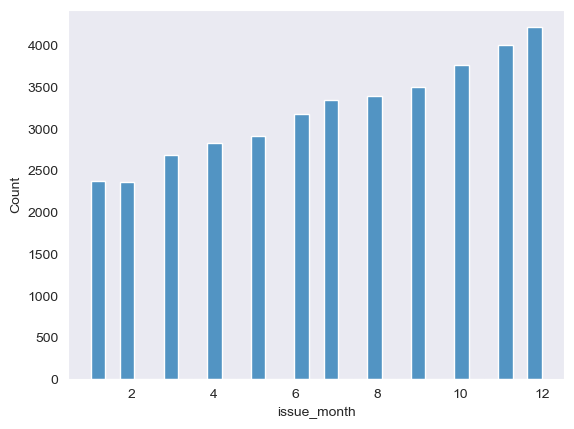

In [330]:
sns.histplot(loan_df_loan_stat, x="issue_month")
plt.show()
#Maximuam loans are given in the second half of the year

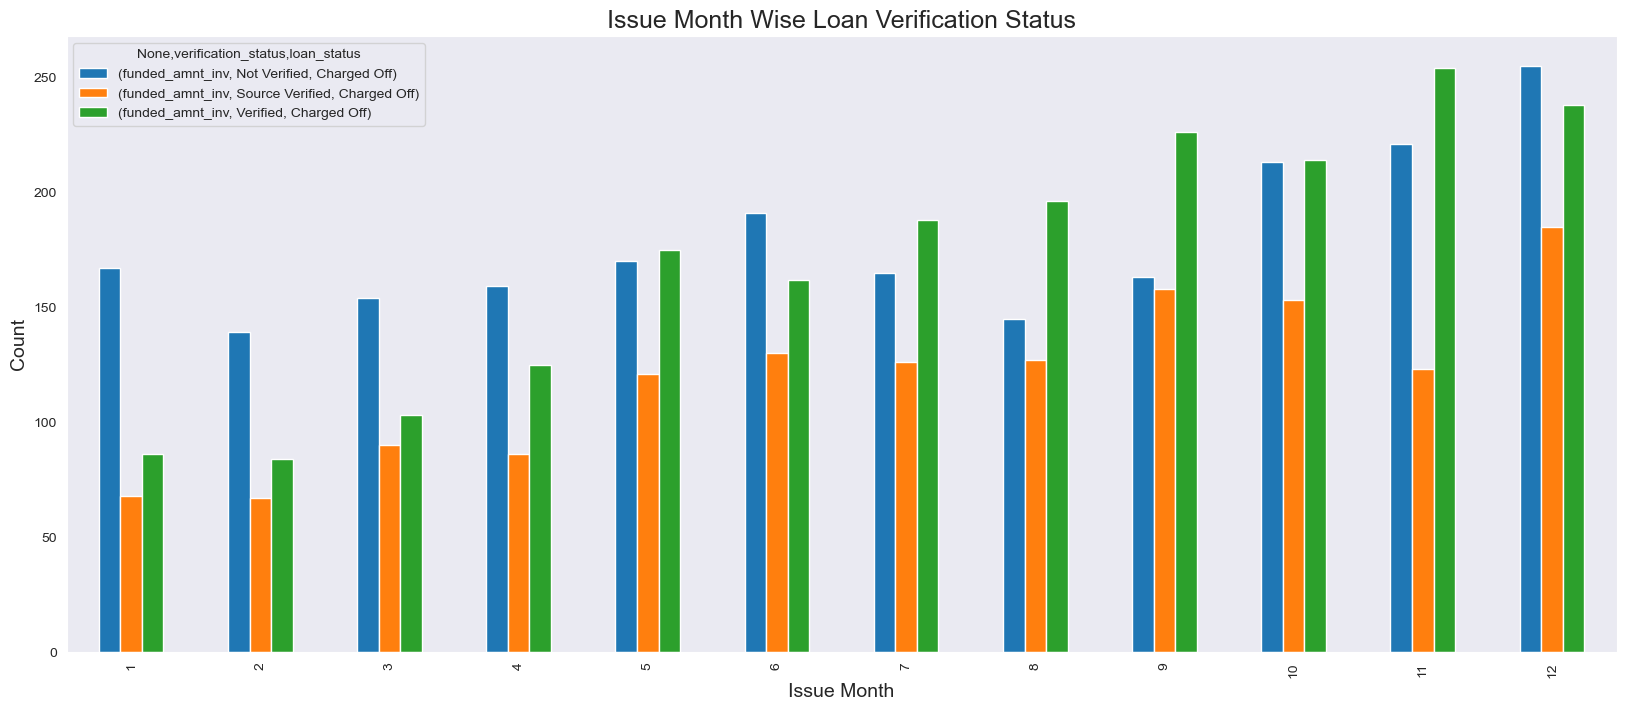

In [331]:
month_verification = pd.pivot_table(data=loan_df_loan_stat[loan_df_loan_stat['loan_status'].isin(['Charged Off'])],  
                    index=["issue_month"], values=['funded_amnt_inv'], columns = ["verification_status","loan_status"], 
                    aggfunc=len)
month_verification.plot(kind="bar",  figsize=[20,8])
plt.title("Issue Month Wise Loan Verification Status", fontsize=18)
plt.xlabel('Issue Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()
#In the month of Dec, Jan, Feb, Mar, June the loan applications are not verifed most of the times which results in the default.
#Recommendations:
#Verify all the applications income source so the chances of default will reduce and will generate more profit.

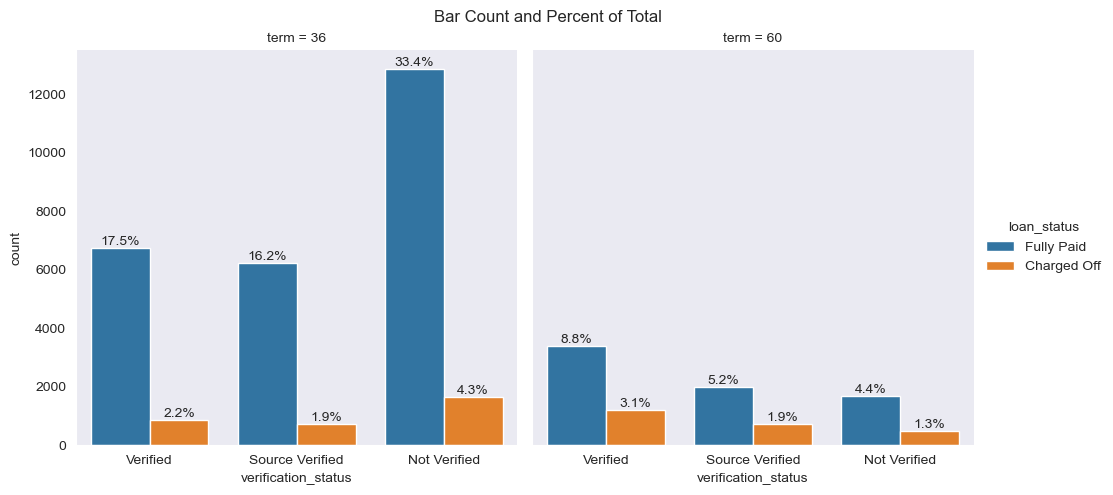

In [332]:
fg = sns.catplot(data=loan_df_loan_stat, kind='count', x='verification_status', hue='loan_status', col='term')
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('Bar Count and Percent of Total')
for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{h/loan_df_loan_stat.loan_status.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.show()
#short term loans are more profit generating
#For long term loans verification is important to generate more profit
#Recomendations:
#Verfication should be mandatory for long term loans

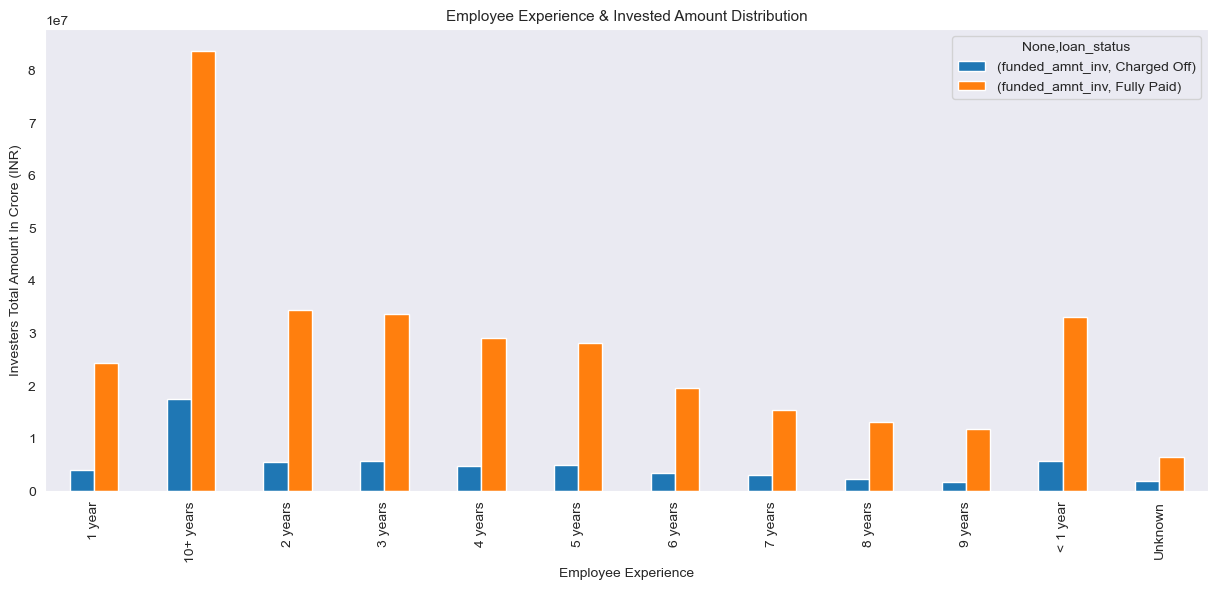

In [333]:
emp_len = pd.pivot_table(data=loan_df_loan_stat,  index=["emp_length"], values=['funded_amnt_inv'], columns = ["loan_status"], aggfunc=sum)
emp_len.plot(kind="bar",  figsize=[15,6])
plt.title("Employee Experience & Invested Amount Distribution", fontsize=11)
plt.xlabel('Employee Experience')
plt.ylabel('Investers Total Amount In Crore (INR)')
plt.show()
#Maximum loan amount given to 10+ year of experience borrowers

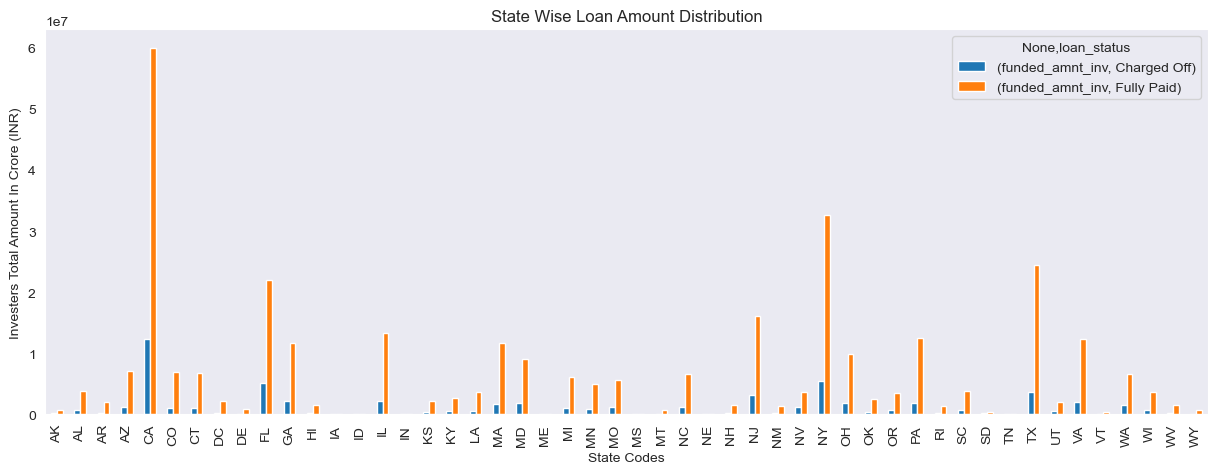

In [334]:
state = pd.pivot_table(data=loan_df_loan_stat,  index=["addr_state"], values=['funded_amnt_inv'], columns = ["loan_status"], aggfunc=sum)
state.plot(kind="bar",  figsize=[15,5], title="State Wise Loan Amount Distribution")
plt.xlabel('State Codes')
plt.ylabel('Investers Total Amount In Crore (INR)')
plt.show()
#The most successful loan distribution is in CA state, followed by NY, TX, FL.
#Recomendation:
#We can prioritize the loan approval as per successful repayment history of states 

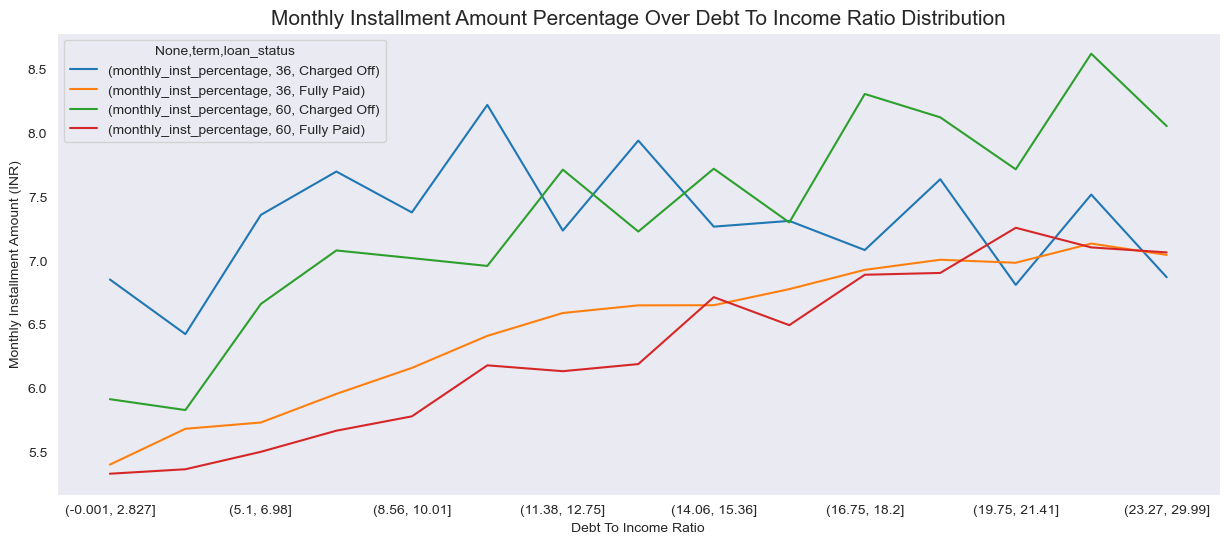

In [335]:
dti = pd.pivot_table(data=loan_df_loan_stat,  index=["dti_bin"], values=['monthly_inst_percentage'], columns = ["term","loan_status"], aggfunc=np.mean)
dti.plot(kind="line",  figsize=[15,6])
plt.title("Monthly Installment Amount Percentage Over Debt To Income Ratio Distribution", fontsize=15)
plt.xlabel('Debt To Income Ratio')
plt.ylabel('Monthly Installment Amount (INR)')
plt.show()
#For both month term monthly installment percentage mean for charged off accounts is always higher than fully paid accounts. 
#For short term (36 months) loans credit amount is more for low dti ratio 
#and for long term (60 months) loans credit amount is high for higher dti ratio values 
#Recomendations
#So need to decrease the invested amount with respect to dti ratio for both term loan

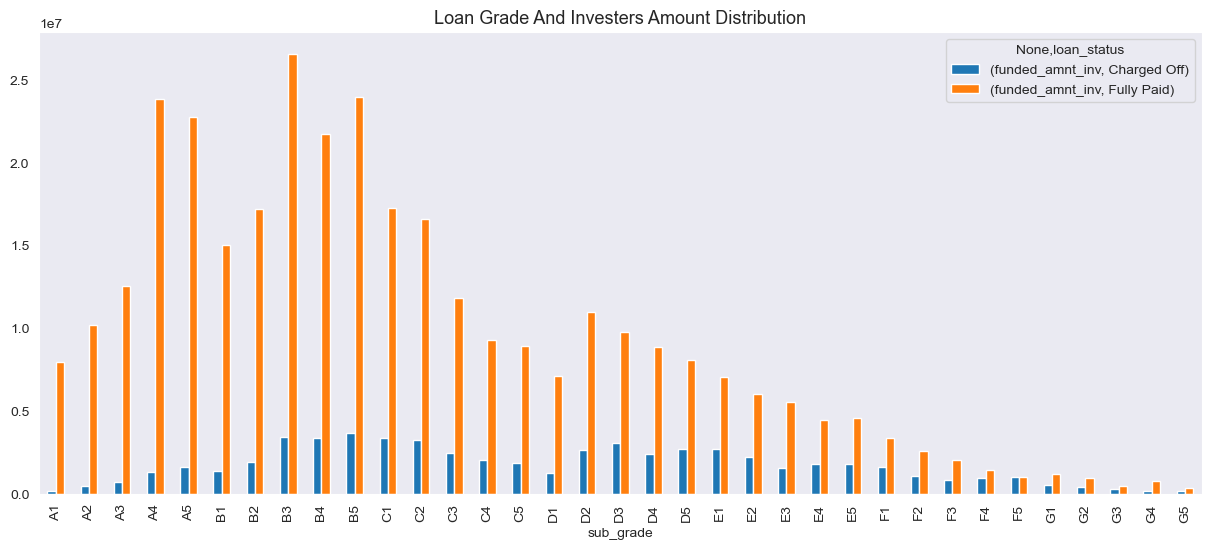

In [336]:
emp_len = pd.pivot_table(data=loan_df_loan_stat,  index=["sub_grade"], values=['funded_amnt_inv'], columns = ["loan_status"], aggfunc=sum)
emp_len.plot(kind="bar",  figsize=[15,6])
plt.title("Loan Grade And Investers Amount Distribution", fontsize=13)
plt.show()
#A & B & c grade loans are more successfully repaid & generated profit

In [340]:
import plotly.offline as py 
import plotly.graph_objs as go # it's like "plt" of matplot
FullyPaid = go.Box(
    y=loan_df_loan_stat[loan_df_loan_stat['loan_status']=='Fully Paid']["funded_amnt_inv"],
    x=loan_df_loan_stat[loan_df_loan_stat['loan_status']=='Fully Paid']["purpose"],
    name='Fully Paid',
    marker=dict(
        color='#3D9970'
    )
)
ChargedOff = go.Box(
    y=loan_df_loan_stat[loan_df_loan_stat['loan_status']=='Charged Off']["funded_amnt_inv"],
    x=loan_df_loan_stat[loan_df_loan_stat['loan_status']=='Charged Off']["purpose"],
    name='Charged Off',
    marker=dict(
        color='#FF4136'
    )
)
data = [FullyPaid, ChargedOff]
layout = go.Layout(
    yaxis=dict(
        title='Invested Amount (INR)',
        zeroline=False
    ),
    xaxis=dict(
        title='Loan Purpose'
    ),
    boxmode='group',
    title='Invested Amount & Loan Purpose Distribution'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-purpose')
#debt_consolidation & small_business with high credit amount are more like to default
#Recomendations:
#Reduce higher credit amount to debt_consolidation & small_business

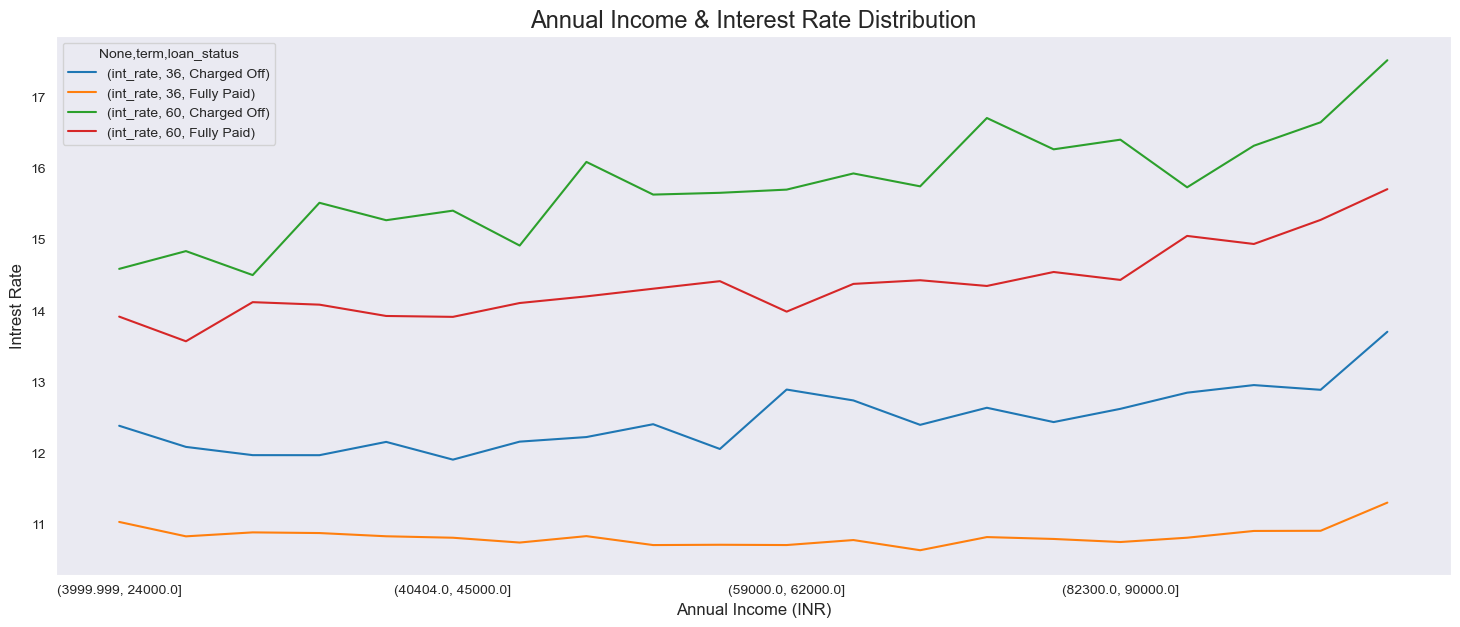

In [338]:
emp_len = pd.pivot_table(data=loan_df_loan_stat,  index=["ann_inc_bin"], values=['int_rate'], columns = ["term","loan_status"], aggfunc=np.mean)
emp_len.plot(kind="line",  figsize=[18,7])
plt.title("Annual Income & Interest Rate Distribution", fontsize=17)
plt.xlabel('Annual Income (INR)', fontsize=12)
plt.ylabel('Intrest Rate', fontsize=12)
plt.show()
#high interest rate loan accounts are more likely to default
#Recomendations
#Reduce credit amount for high interest rate